In [53]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['axes.labelsize']    = 6
mpl.rcParams['font.size']         = 8
# mpl.rcParams['lines.linewidth']   = 0.75
# mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import pandas as pd
# import multiprocessing as mprocs
# from threading import Thread
# from subprocess import Popen, PIPE
# from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from numba import jit, njit, prange
from scipy.stats import linregress
import itertools 

In [54]:
def open_file(a, n, k0, beta, u0, iters, trans, input_dir):

    ## Get Filename
    filename       = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(n, k0, a, beta, u0, iters, trans)
    filename10     = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(n, k0, a, beta, u0, iters, int(trans/10))
    filename100    = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(n, k0, a, beta, u0, iters, int(trans/100))
    filename1000   = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(n, k0, a, beta, u0, iters, int(trans/1000))
    filename10000  = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(n, k0, a, beta, u0, iters, int(trans/10000))
    filename100000 = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/SolverData_ITERS[{}]_TRANS[{}]".format(n, k0, a, beta, u0, iters, int(trans/100000))


    ## Open in current file
    if os.path.exists(input_dir + filename + '.h5'):
        HDFfileData = h5py.File(input_dir + filename + '.h5', 'r')
#         print("a = {:0.3f} || Filename: {}".format(a, filename))
    elif os.path.exists(input_dir + filename10 + '.h5'):
        HDFfileData = h5py.File(input_dir + filename10 + '.h5', 'r')
#         print("a = {:0.3f} || Filename: {}".format(a, filename10))
    elif os.path.exists(input_dir + filename100 + '.h5'):
        HDFfileData = h5py.File(input_dir + filename100 + '.h5', 'r')
#         print("a = {:0.3f} || Filename: {}".format(a, filename100))
    elif os.path.exists(input_dir + filename1000 + '.h5'):
        HDFfileData = h5py.File(input_dir + filename1000 + '.h5', 'r')
#         print("a = {:0.3f} || Filename: {}".format(a, filename1000))
    elif os.path.exists(input_dir + filename10000 + '.h5'):
        HDFfileData = h5py.File(input_dir + filename10000 + '.h5', 'r')
#         print("a = {:0.3f} || Filename: {}".format(a, filename10000))
    elif os.path.exists(input_dir + filename100000 + '.h5'):
        HDFfileData = h5py.File(input_dir + filename100000 + '.h5', 'r')
#         print("a = {:0.3f} || Filename: {}".format(a, filename100000))
    else:
        print("File doesn't exist!...Alpha = {:.3f}".format(a))
        return -1


    return HDFfileData


def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    # print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b


In [55]:
#########################
##  Get Input Parameters
#########################
k0    = 1
N     = [1024, 2048, 4096, 8192, 16384]
alpha = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.2, 2.5]
beta  = 0.0
u0    = 'RANDOM'
iters = int(1e7)
trans = 1000000

######################
##  Input & Output Dir
######################
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/PhaseOrder"


nn = [int(N[i] / 2 - k0) for i in range(len(N))]


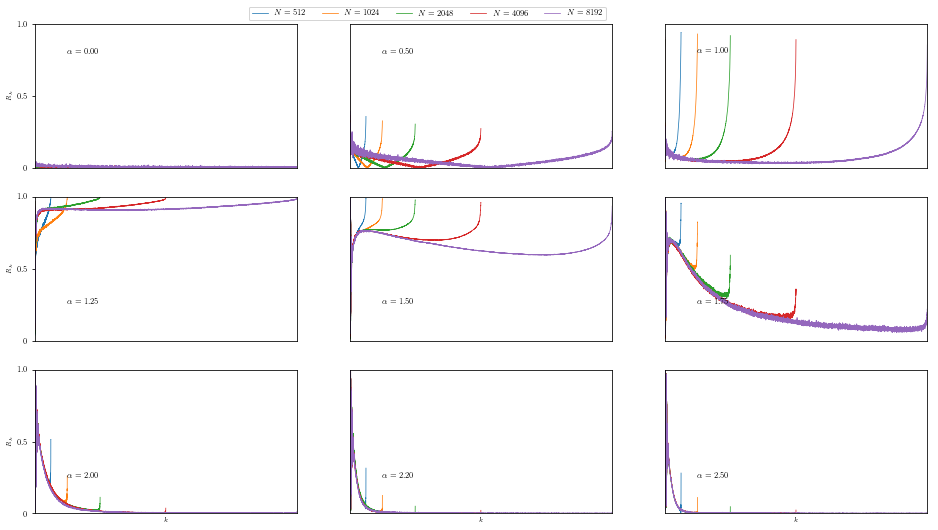

In [56]:
alpha = [0.0, 0.5, 1.0, 1.25, 1.5, 1.75, 2.0, 2.2, 2.5]

fig = plt.figure(tight_layout = False)
xg = 3
yg = 3
gs  = GridSpec(xg, yg)  

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

lnN = np.zeros((len(alpha), len(N)))

for i, a in enumerate(alpha):
    for j, n in enumerate(N):  
        file = open_file(a, n, k0, beta, u0, iters, trans, input_dir)

        R_k_avg = file['R_k_avg']


        ax[i].plot(range(k0 + 1, int(n / 2) + 1), R_k_avg[k0 + 1:], linewidth = 0.75)
        # ax[i].set_xscale('log')
        ax[i].set_xticks([])
        ax[i].set_xticklabels([])
        ax[i].set_yticks([])
        ax[i].set_yticklabels([])


        lnN[i, j] = np.sum(R_k_avg[k0 + 1:])

for i in range(3):
    ax[(yg - 1) * 3 + i].set_xlabel(r"$k$")

for i in range(3):
    ax[i * 3 + 0].set_ylabel(r"$R_k$")
    ax[i * 3 + 0].set_yticks([0, 0.5, 1])
    ax[i * 3 + 0].set_yticklabels([0, 0.5, 1.0])

for i, a in enumerate(alpha):
    if i <= 2:
        ax[i].text(1000, 0.8, r"$\alpha = {:0.2f}$".format(a))
    else:
        ax[i].text(1000, 0.25, r"$\alpha = {:0.2f}$".format(a))
    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(k0 + 1, int(n / 2))
ax[0].legend([r"$N = {}$".format(int(n / 2)) for n in N], bbox_to_anchor = (0.8, 1.0, 1, 0.2), loc="lower left", ncol = len(N))
plt.show()
        

a = 0.00 || slope_bf = 0.7968149754415327, slope_rr = 0.7970770732106098, slope_poly = 1.3867546919651754
a = 0.50 || slope_bf = 1.1950960804588544, slope_rr = 1.1959689879816322, slope_poly = 1.386198349541407
a = 1.00 || slope_bf = 1.4857202381167116, slope_rr = 1.4906876494400747, slope_poly = 1.3825882436108445
a = 1.25 || slope_bf = 0.9379108737545653, slope_rr = 0.9445162457108011, slope_poly = 1.377509531055648
a = 1.50 || slope_bf = 1.0416212715320436, slope_rr = 1.045221485019572, slope_poly = 1.3824326608234718
a = 1.75 || slope_bf = 1.6980257039437987, slope_rr = 1.7383877388638247, slope_poly = 1.355002459960228
a = 2.00 || slope_bf = 5.178246491349133, slope_rr = 6.865092049250751, slope_poly = 1.1570522718084904
a = 2.20 || slope_bf = 12.231643925909545, slope_rr = 16.854565179143822, slope_poly = 1.0067224434723712
a = 2.50 || slope_bf = 16.055271929241297, slope_rr = 16.34131090629375, slope_poly = 1.3629290441647133


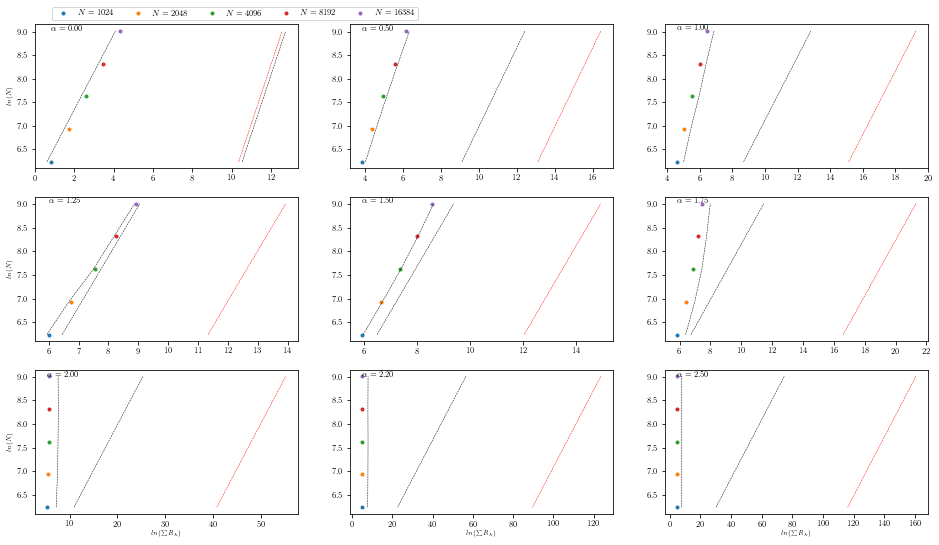

In [57]:
fig = plt.figure(tight_layout = False)
xg = 3
yg = 3
gs  = GridSpec(xg, yg)  


Polynomial = np.polynomial.Polynomial

ax = []
for i in range(xg):
    for j in range(yg):
        ax.append(fig.add_subplot(gs[i, j]))

nn = [int(N[i] / 2 - k0) for i in range(len(N))]
for i, a in enumerate(alpha):
    intercept_bf, slope_bf = best_fit(np.log(lnN[i, :]), np.log(nn))
    slope_rr = (np.log(nn[-1]) - np.log(nn[0])) / (np.log(lnN[i, -1]) - np.log(lnN[i, 0]))
    pfit, stats = Polynomial.fit(np.log(lnN[i, :]), np.log(nn), 1, full = True)#, window = (min(nn), max(nn)), domain = (min(nn), max(nn)))
    intercept_poly, slope_poly = pfit
    
    print("a = {:0.2f} || slope_bf = {}, slope_rr = {}, slope_poly = {}".format(a, slope_bf, slope_rr, slope_poly))
    
    for j in range(len(N)):
        ax[i].plot(np.log(lnN[i, j]), np.log(nn[j]), '.')
    
    ax[i].plot([intercept + slope_bf * np.log(n) for n in N], np.log(nn),  '--', lw = 0.5, color = 'red')
    ax[i].plot(pfit(np.log(nn)), np.log(nn),  '--', lw = 0.5, color = 'black')
    ax[i].plot(np.log(lnN[i, :] * slope_rr), np.log(nn),  '--', lw = 0.5, color = 'black')
    ax[i].text(np.log(lnN[i, 0]), max(np.log(nn)), r"$\alpha = {:0.2f}$".format(a))

    
    #     if i <= 5:
#         ax[i].set_xticks([])
#         ax[i].set_xticklabels([])
#     if np.mod(i, 3) != 0:
#         ax[i].set_yticks([])
#         ax[i].set_yticklabels([])

for i in range(3):
    ax[(yg - 1) * 3 + i].set_xlabel(r"$ln(\sum R_k)$")

for i in range(3):
    ax[i * 3 + 0].set_ylabel(r"$ln(N)$")

ax[0].legend([r"$N = {}$".format(n) for n in N], bbox_to_anchor = (0.05, 1.0, 1, 0.2),loc="lower left", ncol = len(N))
plt.show()

7.623349752914455 1.3867546919651754
7.942671827320095 1.347703364054583
7.629889585417288 1.38668485046728
7.631646654492251 1.3871544479813942
7.637981254815253 1.385977797911945
7.646091166041728 1.386198349541407
7.656819858495902 1.3873456967576494
7.691035855884129 1.389375152686469
7.6773210998954315 1.403967656173072
7.693674949830731 1.4150426956311255
7.635265275526533 1.3825882436108445
7.671127806529502 1.396030471461721
7.668266045827258 1.4029790760834908
7.608103625842409 1.3829071207075578
7.574193514558691 1.3703273778464924
7.576107928876451 1.3824326608234718
7.543115360162926 1.3772033103318873
7.491665956454404 1.3805119284327962
7.4895639768568 1.403557792946925
7.297812554558849 1.2906089566440488
7.212180691549056 1.1570522718084904
7.3869650331217604 1.3747241502189365
7.416920467691405 1.0067224434723712
7.679765195191616 1.1854276013976148
7.985258355449674 1.2631933580651316
7.744535085740597 1.3629290441647133


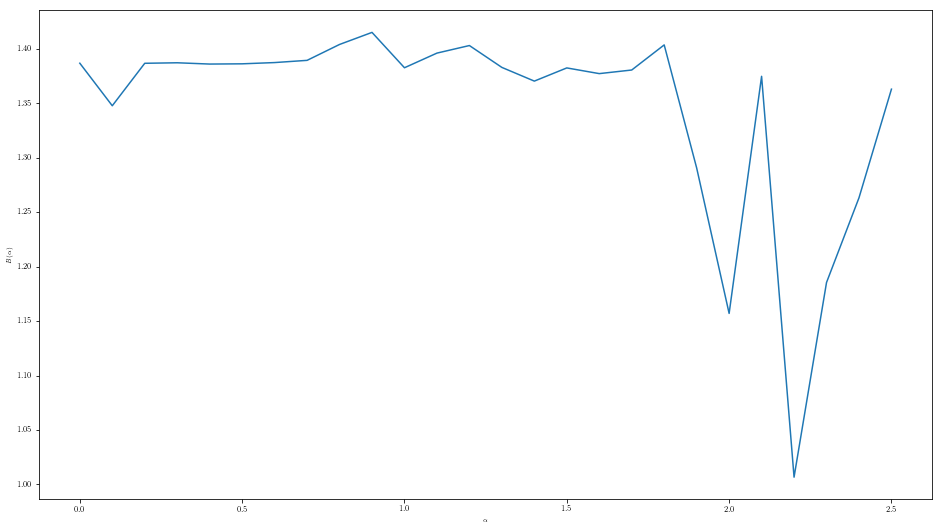

In [60]:
alpha = np.arange(0.0, 2.51, 0.1)
lnNN = np.zeros((len(N), ))
slope = np.zeros((len(alpha), ))

for i, a in enumerate(alpha):
    for j, n in enumerate(N):

        file = open_file(a, n, k0, beta, u0, iters, trans, input_dir)

        R_k_avg = file['R_k_avg']

        lnNN[j] = np.sum(R_k_avg[k0 + 1:])

    pfit, stats = Polynomial.fit(np.log(lnNN), np.log(nn), 1, full = True)#, window = (min(nn), max(nn)), domain = (min(nn), max(nn)))
    intercept, slope[i] = pfit#interc, slope[i] = best_fit(np.log(lnNN), np.log(nn)) # (np.log(lnN[-1]) - np.log(lnN[0])) / (np.log(nn[-1]) - np.log(nn[0]))# (lnN[-1] - lnN[0]) / (nn[-1] - nn[0])
    print(intercept, slope[i])

fig = plt.figure(tight_layout = False)
plt.plot(alpha, slope)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$B(\alpha)$")
plt.show()